In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
import tensorflow as tf
import tensorflow.keras as keras
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
print(f'tf: {tf.__version__}, keras: {keras.__version__}')

tf: 2.8.0, keras: 2.8.0


In [4]:
from tensorflow.keras import layers

In [5]:
# for managing all model metadata, use neptune.ai:
import neptune.new as neptune
from neptune.new.integrations.tensorflow_keras import NeptuneCallback
neptune.__version__

'0.15.2'

In [6]:
import numpy as np

import sys
sys.path.insert(0, '..')
import ml_utils
import pose_utils
from pose_utils import DEG_TO_RAD
from pose_utils import RAD_TO_SCALED
from pose_utils import MAX_DEPTH
from pose_utils import METERS_TO_SCALED
from pose_utils import INTENSITY_TO_SCALED

In [7]:
# tf_data_path = '/data/all_around_zones_3500_tf_data'
# tf_data_path = '/data/all_around_scout_4501_tf_data'
# tf_data_path = '/data/face_to_face_zones_2500_tf_data'
# tf_data_path = '/data/hopper_4500_tf_data'
tf_data_path = '/data/t_formation_zones_3500_tf_data'

In [8]:
ds_train = ml_utils.load_dataset(tf_data_path + '_train', compression='GZIP')
ds_val = ml_utils.load_dataset(tf_data_path + '_val', compression='GZIP')
ds_test = ml_utils.load_dataset(tf_data_path + '_test', compression='GZIP')

n_channels = 4

In [9]:
### (optional) 
### test performance with a subset of input data 
### (instead of RGBD, try other combinations and color spaces)
# import cv2
# def remove_band(image, b):
#     image = np.delete(image, b, -1)
#     return image

# def rgb_to_hsv(image):
#     image = image.numpy() * 255.
#     hsv = cv2.cvtColor(image.astype('uint8'), cv2.COLOR_RGB2HSV) / 255.
#     return hsv

# def rgbd_to_hsvd(image):
#     image = image.numpy()
#     img = image[:,:,:3] * 255.
#     hsv = cv2.cvtColor(img.astype('uint8'), cv2.COLOR_RGB2HSV) / 255.
#     image[:,:,:3] = hsv
#     return image

# def rgbd_to_hvd(image):
#     img = image[:,:,:3].numpy() * 255.
#     hsv = cv2.cvtColor(img.astype('uint8'), cv2.COLOR_RGB2HSV) / 255.
#     hv = remove_band(hsv, 1)
#     image = remove_band(image, 1)
#     image[:,:,:2] = hv
#     return image

# def rgbd_to_hv(image):
#     image = image.numpy()
#     img = image[:,:,:3] * 255.
#     hsv = cv2.cvtColor(img.astype('uint8'), cv2.COLOR_RGB2HSV) / 255.
#     image[:,:,:3] = hsv
#     return remove_band(image, 1)[:,:,:2]

# def rgbd_to_hd(image):
#     image = image.numpy()
#     img = image[:,:,:3] * 255.
#     hsv = cv2.cvtColor(img.astype('uint8'), cv2.COLOR_RGB2HSV) / 255.
#     image[:,:,:3] = hsv
#     image = remove_band(image, 1) # remove s
#     image = remove_band(image, 1) # remove v
#     return image

# n_channels = 1
# mapper = lambda image, label: (image[:,:,-1], label)  # only Depth
# n_channels = 3
# mapper = lambda image, label: (image[:,:,:3], label)  # only RGB
# n_channels = 3
# mapper = lambda image, label: (tf.py_function(func=remove_band, inp=[image, 1], Tout=tf.float64), label)  # only Red + Blue + Depth
# n_channels = 2
# mapper = lambda image, label: (tf.py_function(func=remove_band, inp=[image[:,:,:3], 1], Tout=tf.float64), label)  # only Red + Blue
# n_channels = 3
# mapper = lambda image, label: (tf.py_function(func=rgb_to_hsv, inp=[image[:,:,:3]], Tout=tf.float64), label)  # HSV
# n_channels = 4
# mapper = lambda image, label: (tf.py_function(func=rgbd_to_hsvd, inp=[image], Tout=tf.float64), label)  # HSV + Depth
# n_channels = 3
# mapper = lambda image, label: (tf.py_function(func=rgbd_to_hvd, inp=[image], Tout=tf.float64), label)  # only Hue and Value + Depth
# n_channels = 2
# mapper = lambda image, label: (tf.py_function(func=rgbd_to_hv, inp=[image], Tout=tf.float64), label)  # only Hue and Value
# n_channels = 2
# mapper = lambda image, label: (tf.py_function(func=rgbd_to_hd, inp=[image], Tout=tf.float64), label)  # only Hue + Depth
# ds_train = ds_train.map(mapper)
# ds_val = ds_val.map(mapper)
# ds_test = ds_test.map(mapper)

img shape: (480, 640, 4), found 4 channels
raw:   d = 0.162 , theta = -0.410    , yaw = 0.042 
human: d = 4.05 m, theta = -73.8 deg, yaw = 7.5 deg


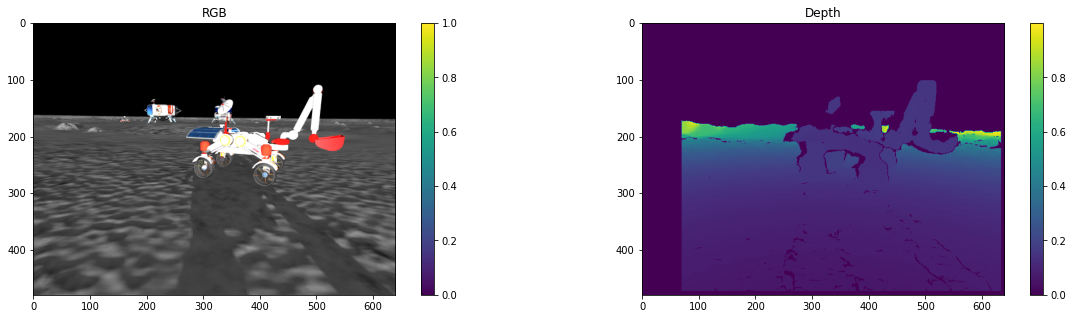

In [10]:
for image, label in ds_train.take(1):
    pose_utils.show_rgbd(image, format='rgbd')
    d, theta, yaw = label.numpy()
    print(f"raw:   d = {d:.3f} , theta = {theta:.3f}    , yaw = {yaw:.3f} ")
    print(f"human: d = {d / METERS_TO_SCALED:.2f} m, theta = {theta / RAD_TO_SCALED / DEG_TO_RAD:.1f} deg, yaw = {yaw / RAD_TO_SCALED / DEG_TO_RAD:.1f} deg")

In [11]:
PROJECT = 'ljburtz/relative-pose'
PARAMS = {
    'height': 120,
    'width': 160,
    'channels': n_channels,
    'pool_size' : 2,
    'patience': 8,
    'batch_size': 12,
    'epochs': 300,
    'alpha': 0.5,
    'beta': 5.,
    'description': 'test run'
}
# TAGS = ['all_around']
# TAGS = ['all_around_scout']
# TAGS = ['face_to_face']
# TAGS = ['hopper']
TAGS = ['t_formation']

## Build the model

In [12]:
def make_basic_model(input_shape, height, width, n_outputs, pool_size):

    model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.experimental.preprocessing.Resizing(height, width),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=pool_size),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=pool_size),        
        layers.Conv2D(128, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=pool_size),
        layers.Flatten(),

        layers.Dense(16, activation="relu"),
        layers.BatchNormalization(),
        layers.Dense(16, activation="relu"),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(n_outputs, activation="linear"),
    ]
)
    return model

In [13]:
def make_xception_model(input_shape, height, width, n_outputs, pool_size):
    inputs = keras.Input(shape=input_shape)
    # Image resizing layer
    x = layers.experimental.preprocessing.Resizing(height, width)(inputs)

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [64]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(pool_size, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(previous_block_activation)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(128, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Flatten()(x)
    
    x = layers.Dense(n_outputs*3)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(n_outputs, activation='linear')(x)
    
    return keras.Model(inputs, outputs)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_2 (Resizing)       (None, 120, 160, 4)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 120, 160, 32)      1184      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 60, 80, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 60, 80, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 30, 40, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 30, 40, 128)      

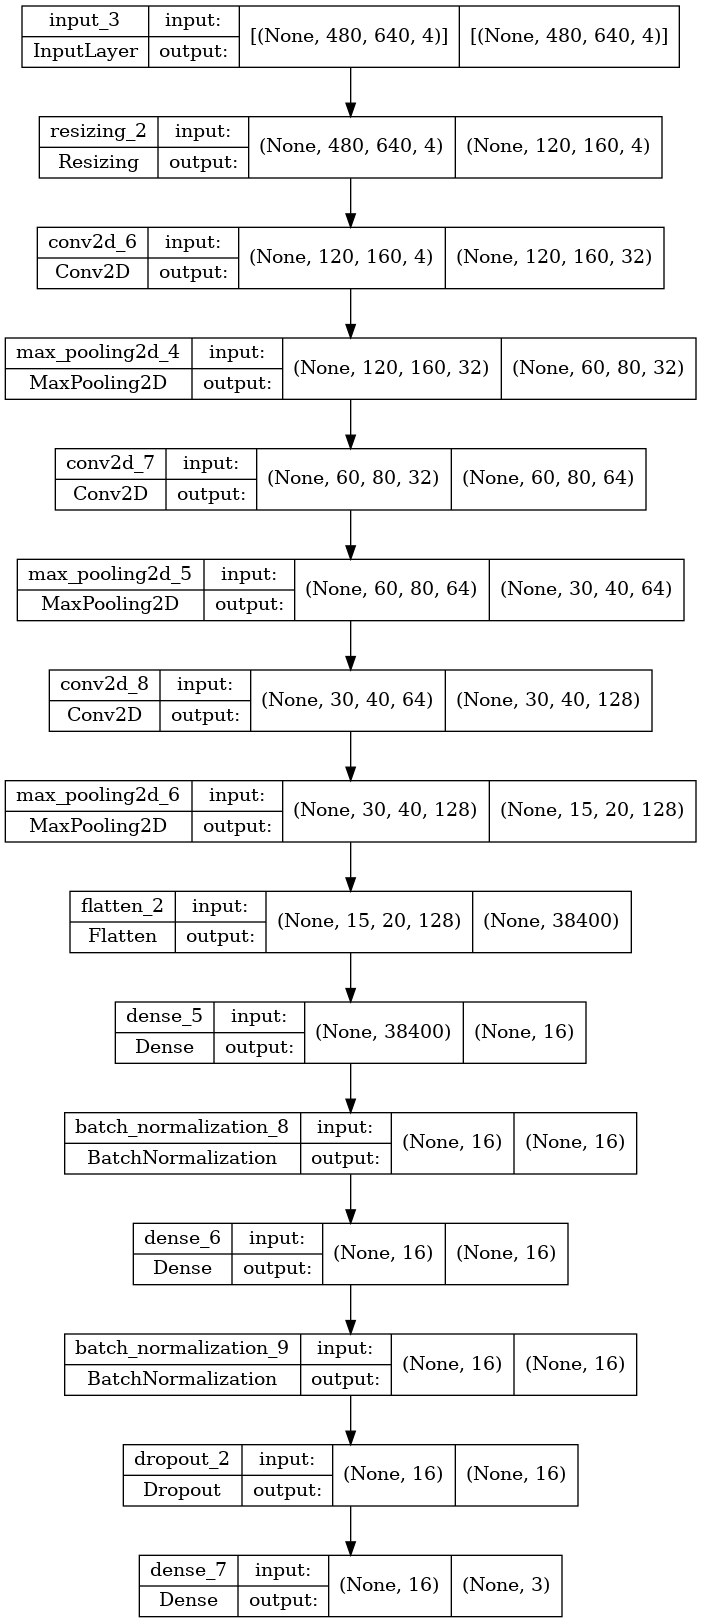

In [16]:
# input_shape = (28, 28, 1) # for MNIST
# input_shape = (32, 32, 3)  # for CIFAR
input_shape = (480, 640, n_channels)
height, width = PARAMS['height'], PARAMS['width']
pool_size = PARAMS['pool_size']
n_outputs = 3

model = make_basic_model(input_shape, height, width, n_outputs, pool_size)
# model = make_xception_model(input_shape, height, width, n_outputs, pool_size)
model.summary()
keras.utils.plot_model(model, show_shapes=True)

## Train the model

In [16]:
batch_size = PARAMS['batch_size']
buffer_size = tf.data.experimental.AUTOTUNE

ds_train_b = ds_train.batch(batch_size, drop_remainder=True)
ds_train_b = ds_train_b.prefetch(buffer_size)
ds_val_b = ds_val.batch(batch_size, drop_remainder=True)
ds_val_b = ds_val_b.prefetch(buffer_size)
ds_test_b = ds_test.batch(batch_size, drop_remainder=True)
ds_test_b = ds_test_b.prefetch(buffer_size)

In [ ]:
epochs = PARAMS['epochs']
alpha = PARAMS['alpha']
beta = PARAMS['beta']

def pose_loss(y_true, y_pred):
    pose_loss = \
        ml_utils.distance_loss(y_true, y_pred) +  \
        alpha * ml_utils.theta_loss(y_true, y_pred) + \
        beta * ml_utils.orientation_loss(y_true, y_pred)
    return pose_loss

def theta_loss(y_true, y_pred):
    return alpha * ml_utils.theta_loss(y_true, y_pred)

def orientation_loss(y_true, y_pred):
    return beta * ml_utils.orientation_loss(y_true, y_pred)

model.compile(
    loss=pose_loss, 
    optimizer='adam', 
    metrics=[
        ml_utils.distance_loss,     # intermediate loss, for tuning alpha and beta
        theta_loss,                 # intermediate loss, for tuning alpha and beta
        orientation_loss,           # intermediate loss, for tuning alpha and beta
        ml_utils.distance_diff,     # intermediate errors: human understandable
        ml_utils.theta_diff,        # intermediate errors: human understandable
        ml_utils.orientation_diff,  # intermediate errors: human understandable
    ]
)

In [17]:
PARAMS, TAGS

({'height': 120,
  'width': 160,
  'channels': 4,
  'pool_size': 2,
  'patience': 8,
  'batch_size': 12,
  'epochs': 300,
  'alpha': 0.5,
  'beta': 5.0,
  'description': 'test run'},
 ['t_formation'])

In [20]:
run = neptune.init(project=PROJECT,
                   tags=TAGS,
#                    mode='debug'
                  )
run_id = run['sys/id'].fetch()
print(run_id)
run.assign({'parameters': PARAMS}, wait=True)  # synchronous call to make sure parameters are synced with the neptune server

https://app.neptune.ai/ljburtz/relative-pose/e/POSE-143
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
POSE-143


In [21]:
callbacks = [
    NeptuneCallback(run=run, base_namespace='metrics'),  # for model metadata logging
    keras.callbacks.ModelCheckpoint(
        '/tmp/best_model_loss.h5', 
        save_weights_only=True,
        save_best_only=True, 
        monitor='val_loss', 
        mode='min'
    ),
    keras.callbacks.ReduceLROnPlateau(),
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
#         min_delta=0.0003,
        mode='min', 
        patience=PARAMS['patience'], 
        verbose=1, 
        restore_best_weights=True
    )
]

In [22]:
history = model.fit(
    ds_train_b, 
    epochs=epochs, 
    validation_data=ds_val_b,
    callbacks=callbacks,
)

Epoch 1/300
139/139 [==============================] - 29s 171ms/step - loss: 0.0378 - distance_loss: 0.0092 - theta_loss: 0.0102 - orientation_loss: 0.0183 - distance_diff: 1.2575 - theta_diff: 17.6616 - orientation_diff: 7.0749 - val_loss: 0.0070 - val_distance_loss: 4.0292e-04 - val_theta_loss: 0.0022 - val_orientation_loss: 0.0044 - val_distance_diff: 0.3802 - val_theta_diff: 9.7708 - val_orientation_diff: 3.7496 - lr: 0.0010
Epoch 2/300
139/139 [==============================] - 21s 154ms/step - loss: 0.0064 - distance_loss: 6.8726e-04 - theta_loss: 0.0023 - orientation_loss: 0.0034 - distance_diff: 0.5202 - theta_diff: 9.7148 - orientation_diff: 3.4727 - val_loss: 0.0059 - val_distance_loss: 2.7336e-04 - val_theta_loss: 0.0018 - val_orientation_loss: 0.0038 - val_distance_diff: 0.3250 - val_theta_diff: 8.4910 - val_orientation_diff: 3.0707 - lr: 0.0010
Epoch 3/300
139/139 [==============================] - 22s 155ms/step - loss: 0.0047 - distance_loss: 5.0423e-04 - theta_loss: 0.

Epoch 20/300
139/139 [==============================] - 22s 158ms/step - loss: 0.0019 - distance_loss: 1.8688e-04 - theta_loss: 6.4424e-04 - orientation_loss: 0.0010 - distance_diff: 0.2679 - theta_diff: 5.1264 - orientation_diff: 1.9292 - val_loss: 0.0039 - val_distance_loss: 2.5290e-04 - val_theta_loss: 9.4012e-04 - val_orientation_loss: 0.0027 - val_distance_diff: 0.2995 - val_theta_diff: 6.0764 - val_orientation_diff: 2.7419 - lr: 0.0010
Epoch 21/300
139/139 [==============================] - 22s 156ms/step - loss: 0.0024 - distance_loss: 2.2749e-04 - theta_loss: 8.1363e-04 - orientation_loss: 0.0013 - distance_diff: 0.2950 - theta_diff: 5.7083 - orientation_diff: 2.2181 - val_loss: 0.0041 - val_distance_loss: 3.1045e-04 - val_theta_loss: 9.1408e-04 - val_orientation_loss: 0.0029 - val_distance_diff: 0.3384 - val_theta_diff: 5.9827 - val_orientation_diff: 2.6690 - lr: 0.0010
Epoch 22/300
139/139 [==============================] - 22s 158ms/step - loss: 0.0020 - distance_loss: 2.288

In [23]:
import json
path = f"/tmp/model_"

# save full model (e.g for resuming training later on)
model.save(path + 'end.h5')

# save model weights and architecture (e.g for inference only)
model.save_weights(path + 'relative_pose_weights.h5')
json_config = model.to_json()
with open(path + 'relative_pose_config.json', 'w') as out_:
    json.dump(json_config, out_)

# log artifacts to Neptune    
run["model/model_end"].upload(path + 'end.h5')
run['model/model_relative_pose_weights'].upload(path + "relative_pose_weights.h5")
run['model/model_relative_pose_config'].upload(path + "relative_pose_config.json")

# log additional metrics
min_loss, min_loss_epoch, min_pdiff, min_pdiff_epoch = ml_utils.get_best_metrics(history, accuracy_metric='distance_diff')
run['metrics/min_loss'] = min_loss
run['metrics/min_loss_epoch'] = min_loss_epoch
run["metrics/min_pdiff"] = min_pdiff
run['metrics/min_pdiff_epoch'] = min_pdiff_epoch
print(run['sys/id'].fetch())

POSE-143


evaluate model on test dataset

In [24]:
results = model.evaluate(ds_test_b)
print("test loss, test metrics:", results)
run['test/avg_position_diff'] = results[-3]
run['test/avg_theta_diff'] = results[-2]
run['test/avg_orientation_diff'] = results[-1]

20/20 [==============================] - 3s 132ms/step - loss: 0.0015 - distance_loss: 1.3818e-04 - theta_loss: 5.3027e-04 - orientation_loss: 8.6247e-04 - distance_diff: 0.2292 - theta_diff: 4.7054 - orientation_diff: 1.7038
test loss, test metrics: [0.001530918525531888, 0.00013818212028127164, 0.0005302670178934932, 0.0008624695474281907, 0.22918100655078888, 4.705419063568115, 1.703779935836792]


In [25]:
n_pred = 100
d_true, theta_true, yaw_true, d_list, theta_list, yaw_list = ml_utils.predict_and_scale(
    model,
    ds_test,
    ds_test_b,
    n_pred,
    batch_size
)

In [31]:
fig = pose_utils.compare_optical_poses(
    d_true, theta_true, yaw_true, 
    d_list, theta_list, yaw_list, 
    yaw_viz_offset=np.pi/2.,
#     footprint='small_scout_1'
#     footprint='processing_plant'
    footprint='small_excavator_1'
)
fig

In [27]:
run['test/compare_poses'].upload(neptune.types.File.as_html(fig))
run['test/compare_poses_png'].upload(neptune.types.File.as_image(fig))

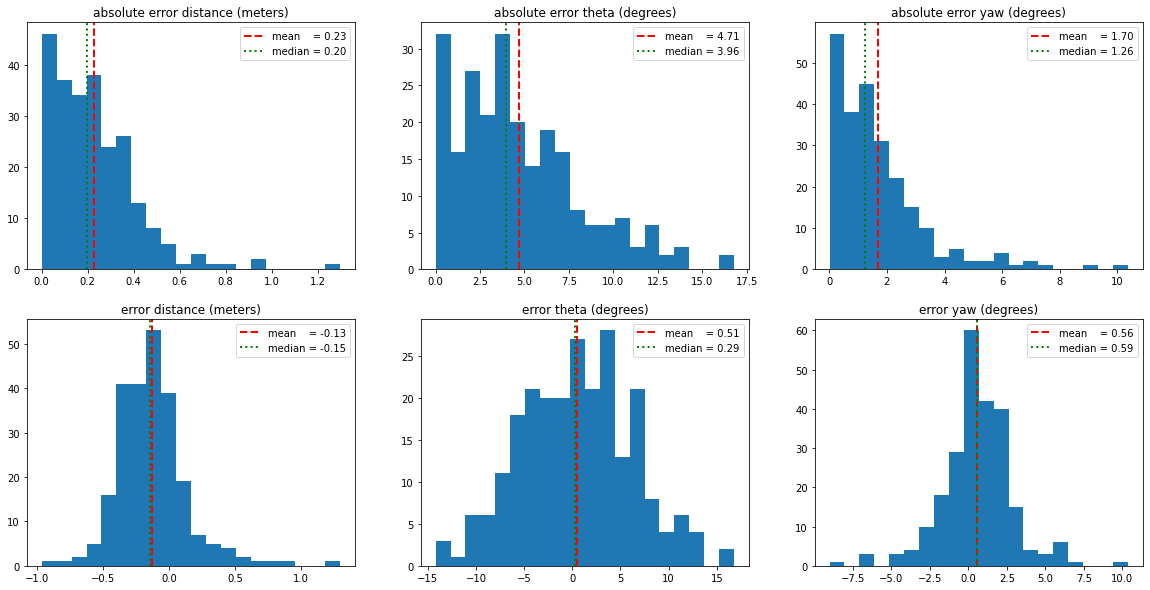

In [28]:
fig = pose_utils.hist_errors(
    d_true, theta_true, yaw_true, 
    d_list, theta_list, yaw_list
)

In [29]:
run['test/error_hist'].upload(neptune.types.File.as_image(fig))

In [30]:
run.stop()

Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 6 operations to synchronize with Neptune. Do not kill this process.


All 6 operations synced, thanks for waiting!
